# <b><h1 style="text-align:center;">Text Categorization</h1></b>
![Text Categorization](image_text_classification.png) 

In [1]:

import pandas as pd
import spacy
from spacy.language import Language

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.metrics import classification_report

In [11]:
# read dataset 
data = pd.read_csv("data.csv")
data.head()

,class_name,text
0,business,Lufthansa flies back to profit\n\nGerman airli...
1,business,Winn-Dixie files for bankruptcy\n\nUS supermar...
2,business,US economy still growing says Fed\n\nMost area...
3,business,Saab to build Cadillacs in Sweden\n\nGeneral M...
4,business,Bank voted 8-1 for no rate change\n\nThe decis...


# Data Processing 

* The treatments listed below are used according to the methods presented in the following article.

In [12]:
# Load the English spaCy model
nlp: Language = spacy.load("en_core_web_sm")

# Define the list of stop words from the spaCy model
stop_words = nlp.Defaults.stop_words

def preprocess_text_spacy(text: str) -> str:
    """
    Preprocesses a text using spaCy:
    - Tokenization
    - Lowercasing and punctuation removal
    - Stop word removal
    - Lemmatization
    """
    # Initial processing to get tokens
    doc = nlp(text)

    # Keep only alphanumeric tokens and convert them to lowercase
    tokens = [token.text.lower() for token in doc if token.text.isalnum()]

    # Remove stop words
    filtered_tokens = [token for token in tokens if token not in stop_words]

    # Reprocess the cleaned text for lemmatization
    cleaned_text = " ".join(filtered_tokens)
    doc_cleaned = nlp(cleaned_text)

    # Extract lemmas
    lemmatized_tokens = [token.lemma_ for token in doc_cleaned]

    return " ".join(lemmatized_tokens)


In [13]:
data["text"] = data["text"].apply(preprocess_text_spacy)

In [14]:
data.head()

,class_name,text
0,business,lufthansa fly profit german airline lufthansa ...
1,business,winn dixie file bankruptcy supermarket group w...
2,business,economy grow say fed area see economy continue...
3,business,saab build cadillacs sweden general motor worl...
4,business,bank vote 8 1 rate change decision interest ra...


In [15]:
# Label Encoder
encoder = LabelEncoder()
data["digital_class"] = encoder.fit_transform(data["class_name"])

In [16]:
data.head()

,class_name,text,digital_class
0,business,lufthansa fly profit german airline lufthansa ...,0
1,business,winn dixie file bankruptcy supermarket group w...,0
2,business,economy grow say fed area see economy continue...,0
3,business,saab build cadillacs sweden general motor worl...,0
4,business,bank vote 8 1 rate change decision interest ra...,0


# Data Splitting

In [17]:
X_train, X_test, y_train, y_test = train_test_split(data["text"], data["digital_class"], test_size=0.2)

# Feature Extraction

In [18]:


vectorizer = TfidfVectorizer(max_features = 500)
vectorizer.fit(X_train)
X_train_vec = vectorizer.transform(X_train)
X_test_vec = vectorizer.transform(X_test)
X_train_vec.shape

(800, 500)

# Modeling and Evaluation

In [19]:
def create_pipeline(model, k):
    return Pipeline([
        ('select', SelectKBest(score_func=chi2, k=k)),
        ('clf', model)
    ])


In [20]:
def train_with_grid_search(X_train, y_train, X_test, y_test, model_name, k_values):
    if model_name == 'svm':
        model = SVC()
        param_grid = {
            'select__k': k_values,
            'clf__C': [0.1, 1, 10],
            'clf__kernel': ['linear', 'rbf']
        }
    elif model_name == 'rf':
        model = RandomForestClassifier()
        param_grid = {
            'select__k': k_values,
            'clf__n_estimators': [100, 200],
            'clf__max_depth': [None, 10, 20]
        }
    elif model_name == 'knn':
        model = KNeighborsClassifier()
        param_grid = {
            'select__k': k_values,
            'clf__n_neighbors': [3, 5, 7],
            'clf__weights': ['uniform', 'distance']
        }
    else:
        raise ValueError("Modèle non reconnu")

    pipeline = create_pipeline(model, k=k_values[0])
    grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)
    print(f"Best params for {model_name}: {grid.best_params_}")
    y_pred = grid.best_estimator_.predict(X_test)
    print(f"Accuracy for {model_name}: ", accuracy_score(y_test, y_pred))
    return grid.best_estimator_


In [21]:
def ensemble_voting(X_train, y_train, X_test, y_test, k_values):
    svm_best = train_with_grid_search(X_train, y_train, X_test, y_test, 'svm', k_values)
    rf_best = train_with_grid_search(X_train, y_train, X_test, y_test, 'rf', k_values)
    knn_best = train_with_grid_search(X_train, y_train, X_test, y_test,'knn', k_values)

    voting = VotingClassifier(estimators=[
        ('svm', svm_best),
        ('rf', rf_best),
        ('knn', knn_best)
    ], voting='hard')

    voting.fit(X_train, y_train)
    return voting


In [22]:
# 
k_values = [100, 200, 300, 400, 500]
final_model = ensemble_voting(X_train_vec, y_train, X_test_vec, y_test, k_values)

# Prediction
y_pred = final_model.predict(X_test_vec)
print("Accuracy:", accuracy_score(y_test, y_pred))


Best params for svm: {'clf__C': 1, 'clf__kernel': 'rbf', 'select__k': 500}
Accuracy for svm:  0.925
Best params for rf: {'clf__max_depth': None, 'clf__n_estimators': 200, 'select__k': 500}
Accuracy for rf:  0.905
Best params for knn: {'clf__n_neighbors': 7, 'clf__weights': 'distance', 'select__k': 500}
Accuracy for knn:  0.88
Accuracy: 0.92


In [23]:
def plot_learning_curve(estimator, X, y, title="Learning Curve", cv=5, scoring='accuracy'):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator,
        X, y,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 5),
        shuffle=True,
        random_state=42
    )

    train_scores_mean = train_scores.mean(axis=1)
    val_scores_mean = val_scores.mean(axis=1)

    plt.figure(figsize=(8, 6))
    
    plt.plot(train_sizes, val_scores_mean, 'o-', color='green', label='Score de validation')
    plt.title(title)
    plt.xlabel("Training sample size")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid()
    plt.tight_layout()
    plt.show()


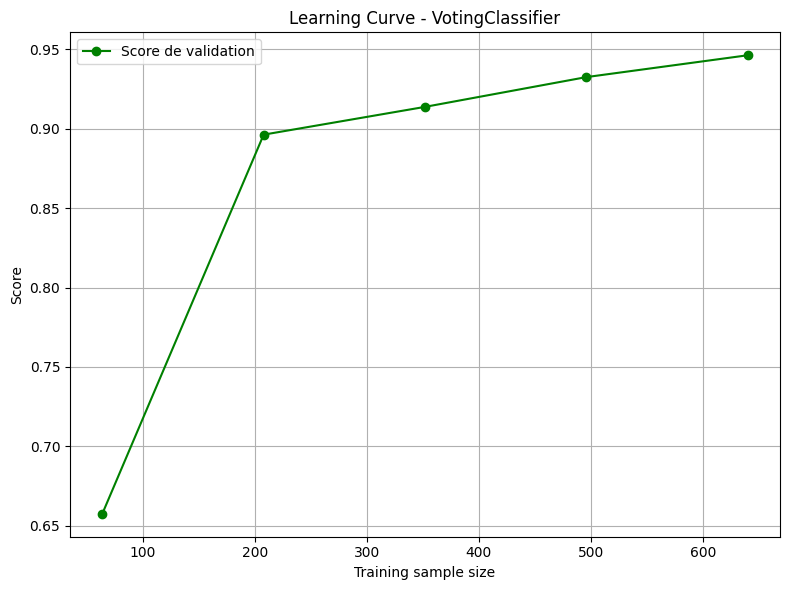

In [24]:
plot_learning_curve(final_model, X_train_vec, y_train, title="Learning Curve - VotingClassifier")


In [25]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87        15
           1       0.93      1.00      0.97        14
           2       0.83      0.95      0.89        21
           3       0.91      1.00      0.95        20
           4       0.95      1.00      0.98        20
           5       0.90      0.93      0.91        28
           6       0.93      0.88      0.90        16
           7       0.89      0.76      0.82        21
           8       1.00      0.92      0.96        25
           9       1.00      0.90      0.95        20

    accuracy                           0.92       200
   macro avg       0.92      0.92      0.92       200
weighted avg       0.92      0.92      0.92       200



#  Save Categories and Model

In [26]:
import json



category_dict = {i: cat for i, cat in enumerate(list(encoder.classes_))}

# Sauvegarder dans un fichier JSON
with open("label_mapping.json", "w", encoding='utf-8') as f:
    json.dump(category_dict, f, ensure_ascii=False, indent=4)


In [27]:
from joblib import dump



dump(final_model, "svm_model.joblib")


['svm_model.joblib']

In [28]:
dump(vectorizer, "vectorizer_tfidf.joblib")

['vectorizer_tfidf.joblib']